In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
sys.path.append("/home/cgarcia_2002/nHits_count")

import functions_nHits  # Importa la función que necesitas
import importlib

importlib.reload(functions_nHits)

<module 'functions_nHits' from '/home/cgarcia_2002/nHits_count/functions_nHits.py'>

In [2]:
root_file_path = "/data/cgarcia_2002/WCTE/data/2384_calib_time/WCTE_offline_R2384S0P0.root"
#root_file_path = "/data/cgarcia_2002/WCTE/data/2385_calib_time/WCTE_offline_R2385S0P2.root"
# Open the ROOT file and get the TTree
file = uproot.open(root_file_path)

tree = file["WCTEReadoutWindows"]  
#tree.show()

In [4]:
times_branch = tree["hit_pmt_calibrated_times"].array(library="np")
event_number_branch = tree["event_number"].array(library="np")

times_branch = tree["hit_pmt_calibrated_times"].array(library="np")[0:1]
event_number_branch = tree["event_number"].array(library="np")[0:1]

range_hits = 10
times_array = np.arange(0, 271000+1, range_hits, dtype=int)
nHits = np.zeros((len(event_number_branch), len(times_array)))

for times, event_number in zip(times_branch, event_number_branch):

    nHits[event_number, :] = functions_nHits.count_nHits(times, range_hits, nHits[event_number, :])

In [5]:
print("nHits shape:", nHits.shape)
print("nHits:", nHits)
print(event_number_branch)

nHits shape: (1, 27101)
nHits: [[0. 0. 0. ... 0. 0. 0.]]
[0]


In [6]:
df_nHits = pd.DataFrame(nHits, columns=[str(t) for t in times_array])
df_nHits.insert(0, "event_number", event_number_branch)

In [7]:
# Crear un nuevo DataFrame con la suma hacia la derecha
df_SumWindow = pd.DataFrame()
# Excluir la columna "event_number"
only_counts = df_nHits.drop(columns="event_number")

# Ahora haces bien el sliding window
for i in range(len(only_counts.columns) - 4):
    col_name = only_counts.columns[i]
    sum_window = only_counts.iloc[:, i:i+5].sum(axis=1)
    df_SumWindow[col_name] = sum_window

    
 #no es dificil añadir que si pasa el threshold guarde el evento y tiempo y no cuente las siguientes ventanas


Max value: 497.0
Row index: 0
Column name: 222100


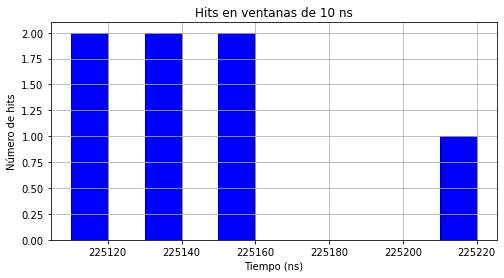

In [8]:
max_value = df_SumWindow.max(axis=1).max()  # Maximum value in the whole DataFrame
idx_row = df_SumWindow.max(axis=1).idxmax()  # Row index of the maximum value
col_name = df_SumWindow.loc[idx_row].idxmax()  # Column name of the maximum value in that row

print("Max value:", max_value)
print("Row index:", idx_row)
print("Column name:", col_name)

# Selecciona la columna inicial y las 10 siguientes
col_start = 225110
col_names = [str(col_start + 10*i) for i in range(11)]

# Selecciona los datos (por ejemplo, de la primera fila)
row = df_nHits.loc[0, col_names]

# Haz el plot
plt.figure(figsize=(8, 4))
plt.bar([int(c) for c in col_names], row.values, width=10, color='blue', align='edge', edgecolor='navy')
plt.xlabel('Tiempo (ns)')
plt.ylabel('Número de hits')
plt.title('Hits en ventanas de 10 ns')
plt.grid(True)
plt.show()

In [9]:
threshold = 5
trigger_times = {}
jump_bins = 10
for idx, row in df_SumWindow.iterrows():
    i = 0
    trigger_times[idx] = []  # inicializa la lista para este evento
    while i < len(row):
        if row.iloc[i] >= threshold:
            # Guardamos el tiempo correspondiente a este trigger
            trigger_time = row.index[i]
            trigger_times[idx].append(trigger_time)
           
            """# Eliminamos los siguientes jump_bins columnas poniéndolas a 0
            end = min(i + jump_bins, len(row))
            row.iloc[i:end] = 0"""

            i += jump_bins  # saltamos
        else:
            i += 1

{0: ['222060', '225110']}
Evento 0, Trigger time: 222060


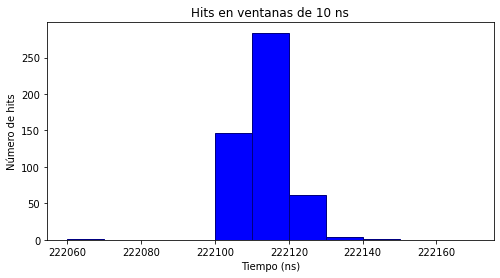

Evento 0, Trigger time: 225110


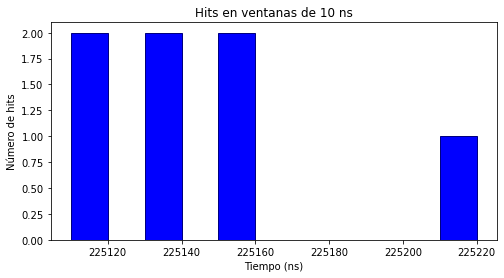

In [10]:
print(trigger_times)

for event_number in trigger_times:
    for start_time in trigger_times[event_number]:

        print(f"Evento {event_number}, Trigger time: {start_time}")
        selected_cols = [str(int(start_time) + 10*i) for i in range(11)]


        # Selecciona los datos (por ejemplo, de la primera fila)
        row = df_nHits.loc[event_number, selected_cols]

        # Haz el plot
        plt.figure(figsize=(8, 4))
        plt.bar([int(c) for c in selected_cols], row.values, width=10, color='blue', align='edge', edgecolor='navy')
        plt.xlabel('Tiempo (ns)')
        plt.ylabel('Número de hits')
        plt.title('Hits en ventanas de 10 ns')
        plt.show()

In [11]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.colors as colors
sys.path.append("/home/cgarcia_2002/WCTE_event_display-main/WCTE_event_display-main")

from EventDisplay import EventDisplay

In [22]:
t_evento = 225110
delta = 50
event_id = 0

# Leer datos
times = tree["hit_pmt_times"].array(library="np")
charges = tree["hit_pmt_charges"].array(library="np")
slot_ids = tree["hit_mpmt_slot_ids"].array(library="np")
pmt_positions = tree["hit_pmt_position_ids"].array(library="np")


t = times[event_id]
q = charges[event_id]
slot = slot_ids[event_id]
pos = pmt_positions[event_id]

# Filtrar por tiempo cercano al evento deseado
mask = (t > t_evento - delta) & (t < t_evento + delta)

# Aplicar filtro
t = t[mask]
q = q[mask]
slot = slot[mask]
pos = pos[mask]

# Combinar en canal único para EventDisplay
channel_ids = slot * 19 + pos

# ---------- VISUALIZAR EVENTO ----------

# Crear instancia del EventDisplay
eventDisplay = EventDisplay()
eventDisplay.load_mPMT_positions('mPMT_2D_projection_angles.csv')
eventDisplay.load_wcsim_tubeno_mapping("geofile_WCTE.txt")

# Procesar y graficar
data_to_plot = eventDisplay.process_data(channel_ids, q)
eventDisplay.plotEventDisplay(data_to_plot, color_norm=colors.Normalize(), style="dark_background")
plt.savefig("evento_filtrado_1.png")
plt.close()


(2014,)
